# [WIP] Simulation

This is a reproduction of the following paper.

Okada, I., Yamamoto, H., Akiyama, E. & Toriumi, F.\
Cooperation in spatial public good games depends on the locality effects of game, adaptation, and punishment.\
Sci Rep 11, 7642 (2021).\
https://doi.org/10.1038/s41598-021-86668-3

In [1]:
using Agents: ABM, AbstractAgent, GraphSpace, add_agent_pos!, allagents, nearby_agents, run!, dummystep, seed!
using CSV: CSV
using LightGraphs: SimpleGraph, cycle_graph, nv, ne
using GraphPlot: gplot
using Statistics: mean
using Test: @test, @testset, @test_throws
using Dates: format, now, millisecond
using Random

println("running on Julia $VERSION ($(Threads.nthreads()) Threads)")

running on Julia 1.6.3 (7 Threads)


# 1. Define agent.

In [2]:
# Cooperative or non-cooperative
const C = true
const D = false

# Punisher or non-punisher
const P = true
const N = false

# Player Agent
mutable struct Player <: AbstractAgent
    id::Int
    pos::Int
    strategy::Tuple{Bool, Bool} # {C or D, P or N}
    next_strategy::Tuple{Bool, Bool} # {C or D, P or N}
    payoff::Float64 # 6 digits

    Player(id::Int, strategy::Tuple{Bool, Bool}) = new(id, id, strategy, (D, N), 0.0)
    Player(id::Int; C_rate::Float64, P_rate::Float64) = new(id, id, (rand() < C_rate, rand() < P_rate), (D, N), 0.0)
end

function strategy(player::Player)::Symbol
    is_c, is_p = player.strategy
    if is_c && is_p
        :CP
    elseif is_c && !is_p
        :CN
    elseif !is_c && is_p
        :DP
    else
        :DN
    end
end

strategy (generic function with 1 method)

In [3]:
# Test
Random.seed!(millisecond(now()))

@testset "Player(id::Int, strategy::Tuple{Bool, Bool})" begin
    p = Player(2, (D, P))
    @test p isa Player
    @test p.id == p.pos == 2
    @test p.strategy == (D, P)
    @test p.next_strategy == (D, N)
    @test p.payoff == 0
end

@testset "Player(id::Int; C_rate::Float64, P_rate::Float64)" begin
    p = Player(3; C_rate=0.001, P_rate=0.999)
    @test p isa Player
    @test p.id == p.pos == 3
    @test p.strategy == (D, P)
    @test p.next_strategy == (D, N)
    @test p.payoff == 0

    p = Player(4; C_rate=0.999, P_rate=0.001)
    @test p.strategy == (C, N)
    @test p.next_strategy == (D, N)

    ps = [Player(id; C_rate=0.5, P_rate=0.5) for id in 1:1000]
    C_or_D = [p.strategy[1] for p in ps]
    P_or_N = [p.strategy[2] for p in ps]
    # println("C_or_D: $(mean(C_or_D)), $C_or_D")
    # println("P_or_N: $(mean(P_or_N)), $P_or_N")
    @test 0.4 <= mean(C_or_D) <= 0.6
    println(mean(C_or_D))
    @test 0.4 <= mean(P_or_N) <= 0.6
    println(mean(P_or_N))
end

Test Summary:                                | Pass  Total
Player(id::Int, strategy::Tuple{Bool, Bool}) |    5      5
0.483
0.504
Test Summary:                                     | Pass  Total
Player(id::Int; C_rate::Float64, P_rate::Float64) |    9      9


Test.DefaultTestSet("Player(id::Int; C_rate::Float64, P_rate::Float64)", Any[], 9, false, false)

# 2. Define a function for building model.

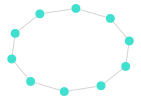

Test Passed
      Thrown: DomainError

In [4]:
function make_network(N::Int = 100, network_type::Symbol = :cycle_graph)
    if network_type == :cycle_graph
        return cycle_graph(N)
    else
        throw(DomainError(network_type, "The network type has not been implemented yet."))
    end
end

# Test
display(gplot(make_network(10)))
@test_throws DomainError make_network(10, :scale_free)

- In each simulation, the parameters on locality (g, p, a) are given as constants.
- In an initial setting of a simulation, all players on a regular graph are set to one of the four types **randomly**.

#### $n$: neighbor parameter
- To consider the locality of each player, one’s neighbors are defined as players within n/2 hops excluding oneself.
    - Note that n should be an even number.
    - For example, if 𝑛 = 4, every player recognizes one’s neighbors as (1) two players directly connected to oneself and (2) two more players directly connected to those directly connected to oneself.
    
#### $g$: game interaction locality parameter
- In the interaction in the game, first, we introduce a parameter, $g ∈ [0,1]$.
- We assume this parameter to be the degree of social (im)mobility.
- All players play a PGG with $n + 1$ players including oneself.
- The other members are randomly chosen from the two pools of players: a pool consisting of one’s n neighbors and a pool consisting of all 𝑁−1 players.
- The ratio of the quantity (we allow non-integer numbers) chosen from each pool is 𝑔:1−𝑔.

#### $p$: punishment locality parameter
- Second, we introduce a parameter, $p ∈ [0,1]$ for dealing with a locality of punishment.
- With a probability, p, a player (if one is a punisher) looks at n players that are randomly chosen among all $N-1$ players excluding oneself and punishes non-cooperators among those $n$ players.
- Otherwise, the player looks at $n$ neighbors and punishes non-cooperators among them.

#### $a$: adaptation (learning) locality parameter
- Finally, we introduce a parameter, $a ∈[0,1]$.
- With a probability, $a$, a player chooses a target player for one’s learning among all $N-1$ players excluding oneself.
- Otherwise, the player chooses a target player among one’s n neighbors.

#### $b = 2$: benefit of a token
- A benefit of a token is set to b

#### $c = 1$: cost
- When playing a PGG, if a player gives a token to a public pod, one must pay a cost, c. Otherwise, no cost is paid.

#### $f = 6$: fine / $s = 3$: sanction for punishment
- If player X punishes player Y, Y loses f as a fine while X pays s as a sanction for the punishment.

#### $\mu = 0.01$: mutation rate
- Moreover, we introduce a mutation rate, $\mu$, to keep the diversity of player types.
- With a probability, 𝜇, an agent uses one of four types randomly in each adaptive process.

In [113]:
function build_model(;
    G::SimpleGraph,
    n::Int = 4,
    g::Float64,
    p::Float64,
    a::Float64,
    b::Float64 = 2.0,
    c::Float64 = 1.0,
    f::Float64 = 6.0,
    s::Float64 = 3.0,
    μ::Float64 = 0.01,
    C_rate::Float64 = 0.5,
    P_rate::Float64 = 0.5
)::ABM
    @assert iseven(n)

    Random.seed!(millisecond(now()))

    model = ABM(Player, GraphSpace(G), properties = Dict(
        :n => n,
        :g => g,
        :p => p,
        :a => a,
        :b => b,
        :c => c,
        :f => f,
        :s => s,
        :μ => μ
    ))

    # モデル上にエージェントを配置する
    foreach(id -> add_agent_pos!(Player(id; C_rate, P_rate), model), 1:nv(G))

    return model
end

build_model (generic function with 1 method)

In [93]:
# Test
@testset "build_model(; G::SimpleGraph)" begin
    @testset "graph structure is circle" begin
        node_count = 35
        model = build_model(; G = make_network(node_count), g=0.3, p=0.4, a=0.5)
        @test nv(model.space.graph) == ne(model.space.graph) == node_count
        for a in allagents(model)
            @test a.id == a.pos
            for neighbor in nearby_agents(a, model, 1)
                if a.id == 1
                    @test neighbor.id == 2 ||  neighbor.id == node_count
                elseif a.id == node_count
                    @test neighbor.id == 1 ||  neighbor.id == node_count - 1
                else
                    @test a.id - neighbor.id == 1 ||  a.id - neighbor.id == -1
                end
            end
        end
    end
    
    @testset "parameters" begin
        model = build_model(; G = make_network(10), g=0.3, p=0.4, a=0.5)
        @test model.n == 4
        @test model.g == 0.3
        @test model.p == 0.4
        @test model.a == 0.5
        @test model.b == 2.0
        @test model.c == 1.0
        @test model.f == 6.0
        @test model.s == 3.0
        @test model.μ == 0.01
        @test_throws AssertionError build_model(; G = cycle_graph(10), n = 5, g=0.3, p=0.4, a=0.5)
    end

    @testset "strategy allocation" begin
        for _ in 1:10
            G = cycle_graph(1000)
            # display(gplot(G))
            model = build_model(; G, g=0.3, p=0.3, a=0.3, C_rate=0.5, P_rate=0.5)
            C_or_D = [player.strategy[1] for player in allagents(model)]
            # println("C_or_D: $(mean(C_or_D)) $(C_or_D)")
            @test 0.4 < mean(C_or_D) < 0.6
            P_or_N = [player.strategy[2] for player in allagents(model)]
            # println("P_or_N: $(mean(P_or_N)) $(P_or_N)")
            @test 0.4 < mean(P_or_N) < 0.6
        end
    end
end

Test Summary:                 | Pass  Total
build_model(; G::SimpleGraph) |  136    136


Test.DefaultTestSet("build_model(; G::SimpleGraph)", Any[Test.DefaultTestSet("graph structure is circle", Any[], 106, false, false), Test.DefaultTestSet("parameters", Any[], 10, false, false), Test.DefaultTestSet("strategy allocation", Any[], 20, false, false)], 0, false, false)

# 3. Define model behavior of 1step.

- Then each player’s expected payoff is calculated and their types are updated in the adaptation process.
- This procedure is repeated and the performances are observed.

## 3.1. Calculate payoff

In [94]:
function agents_not_i(agent::Player, model::ABM)::Tuple{Vector{Player}, Vector{Player}}
    neighbors = nearby_agents(agent, model, Int(model.n / 2))
    neighbors_not_i = [a for a in neighbors if a.id != agent.id]
    allagents_not_i = [a for a in allagents(model) if a.id != agent.id]
    
    return allagents_not_i, neighbors_not_i
end

agents_not_i (generic function with 1 method)

### Calculate $NC_{-i}, nC_{i}, NP_{-i}, nP_{i}$

|||
|---|---|
|$NC_{-i}$|the ratio of cooperators among all 𝑁−1 players excluding oneself (i)|
|$nC_{i}$|the ratio of cooperators among player i’s neighbors|
|$NP_{-i}$|the ratio of punishers among all 𝑁−1 players excluding oneself (i)|
|$nP_{i}$|the ratio of punishers among player i ’s neighbors|

In [95]:
function strategy_rates(agent::Player, model::ABM)::Tuple{Float64, Float64, Float64, Float64}
    allagents_not_i, neighbors_not_i = agents_not_i(agent, model)

    N_C = length([a for a in allagents_not_i if a.strategy[1] == C]) / length(allagents_not_i)
    n_C = length([a for a in neighbors_not_i if a.strategy[1] == C]) / length(neighbors_not_i)
    N_P = length([a for a in allagents_not_i if a.strategy[2] == P]) / length(allagents_not_i)
    n_P = length([a for a in neighbors_not_i if a.strategy[2] == P]) / length(neighbors_not_i)
    
    return N_C, n_C, N_P, n_P
end

strategy_rates (generic function with 1 method)

In [96]:
@testset "strategy_rates" begin
    model = build_model(; G = make_network(10), g=0.3, p=0.4, a=0.5)
    model[1].strategy = (C, P)
    model[2].strategy = (C, P)
    model[3].strategy = (D, P)
    model[4].strategy = (C, N)
    model[5].strategy = (D, N)
    model[6].strategy = (C, N)
    model[7].strategy = (C, P)
    model[8].strategy = (C, P)
    model[9].strategy = (C, N)
    model[10].strategy = (C, N)
    N_C, n_C, N_P, n_P = strategy_rates(model[1], model)
    @test N_C == 7 / 9
    @test n_C == 3 / 4
    @test N_P == 4 / 9
    @test n_P == 2 / 4
end

Test Summary:  | Pass  Total
strategy_rates |    4      4


Test.DefaultTestSet("strategy_rates", Any[], 4, false, false)

### Calculate payoffs

<img src="img/calc_payoffs.png" width="600">

In [115]:
function calc_payoffs!(agent::Player, model::ABM)
    N_C, n_C, N_P, n_P = strategy_rates(agent, model)

    # 協力者が得る利得
    π_C = model.b * (model.n * (model.g * N_C + (1 - model.g) * n_C) + 1) / (model.n + 1) - model.c

    # 非協力者が得る利得
    π_D = model.b * model.n * (model.g * N_C + (1 - model.g) * n_C) / (model.n + 1)

    # Sanction for the punishment (罰のコスト)
    π_P = model.s * (model.p * (1 - N_C) + (1 - model.p) * (1 - n_C))

    # Fine (罰金)
    π_F = model.f * (model.p * N_P + (1 - model.p) * n_P)

    # Payoff
    if agent.strategy == (C, P)
        agent.payoff = π_C - π_P
    elseif agent.strategy == (C, N)
        agent.payoff = π_C
    elseif agent.strategy == (D, P)
        agent.payoff = π_D - π_P - π_F
    elseif agent.strategy == (D, N)
        agent.payoff = π_D - π_F
    end
end

calc_payoffs! (generic function with 1 method)

In [98]:
# Test
model = build_model(; G = make_network(10), g=0.3, p=0.4, a=0.5)
model[1].strategy = (C, P)
model[2].strategy = (C, P)
model[3].strategy = (D, P)
model[4].strategy = (C, N)
model[5].strategy = (D, N)
model[6].strategy = (C, N)
model[7].strategy = (C, P)
model[8].strategy = (C, P)
model[9].strategy = (C, N)
model[10].strategy = (C, N)

@testset "calc_payoffs!" begin
    @testset "payoff in case of CP" begin
        model[1].payoff = 0
        model[1].strategy = (C, P)
        calc_payoffs!(model[1], model)
        N_C, n_C, N_P, n_P = strategy_rates(model[1], model)
        @test model[1].payoff == (2(4(0.3N_C + 0.7n_C) + 1) / 5 - 1) - 3(0.4(1 - N_C) + 0.6(1 - n_C))
        println("payoff in case of CP: $(model[1].payoff)")
    end

    @testset "payoff in case of CN" begin
        model[1].payoff = 0
        model[1].strategy = (C, N)
        calc_payoffs!(model[1], model)
        N_C, n_C, N_P, n_P = strategy_rates(model[1], model)
        @test model[1].payoff == (2(4(0.3N_C + 0.7n_C) + 1) / 5 - 1)
        println("payoff in case of CN: $(model[1].payoff)")
    end

    @testset "payoff in case of DP" begin
        model[1].payoff = 0
        model[1].strategy = (D, P)
        calc_payoffs!(model[1], model)
        N_C, n_C, N_P, n_P = strategy_rates(model[1], model)
        @test model[1].payoff == 2 * 4(0.3N_C + 0.7n_C) / 5 - 6(0.4N_P + 0.6n_P) - 3(0.4(1 - N_C) + 0.6(1 - n_C))
        println("payoff in case of DP: $(model[1].payoff)")
    end

    @testset "payoff in case of DN" begin
        model[1].payoff = 0
        model[1].strategy = (D, N)
        calc_payoffs!(model[1], model)
        N_C, n_C, N_P, n_P = strategy_rates(model[1], model)
        @test model[1].payoff == 2 * 4(0.3N_C + 0.7n_C) / 5 - 6(0.4N_P + 0.6n_P)
        println("payoff in case of DN: $(model[1].payoff)")
    end
end

payoff in case of CP: -0.10333333333333328
payoff in case of CN: 0.6133333333333333
payoff in case of DP: -2.369999999999999
payoff in case of DN: -1.6533333333333329
Test Summary: | Pass  Total
calc_payoffs! |    4      4


Test.DefaultTestSet("calc_payoffs!", Any[Test.DefaultTestSet("payoff in case of CP", Any[], 1, false, false), Test.DefaultTestSet("payoff in case of CN", Any[], 1, false, false), Test.DefaultTestSet("payoff in case of DP", Any[], 1, false, false), Test.DefaultTestSet("payoff in case of DN", Any[], 1, false, false)], 0, false, false)

## 3.2. Update strategy

- Every player has a chance to update one’s type through an adaptation process.
- In the process, every player (X) chooses another player (Y) using the selection rule explained in the part of the definition of $a$.
    - With a probability, $a$, a player chooses a target player for one’s learning among all $N-1$ players excluding oneself.
    - Otherwise, the player chooses a target player among one’s n neighbors.
- We assume that all players simultaneously have an opportunity to revise their types, and we refer to the period until the end of this adaptation as a generation.
- Player X changes one’s strategy to Y’s if and only if Y’s payoff is greater than X’s.
- Moreover, we introduce a mutation rate, $\mu$, to keep the diversity of player types.
- With a probability, $\mu$, an agent uses one of four types randomly in each adaptive process.

In [99]:
function pick_Y(agent::Player, model::ABM)::Player
    allagents_not_i, neighbors_not_i = agents_not_i(agent, model)

    return (model.a > rand() ? allagents_not_i : neighbors_not_i)[rand(1:end)]
end

function set_next_strategies!(agent::Player, model::ABM)
    # Player X changes one’s strategy to Y’s if and only if Y’s payoff is greater than X’s.
    Y::Player = pick_Y(agent, model)
    agent.next_strategy = Y.payoff > agent.payoff ? Y.strategy : agent.strategy

    # With a probability, μ, an agent uses one of four types randomly in each adaptive process.
    (model.μ > rand()) && (agent.next_strategy = [(C, P), (C, N), (D, P), (D, N)][rand(1:end)])
end

function update_strategies!(agent::Player)
    agent.strategy = agent.next_strategy
    # agent.payoff = 0f0 # デバッグしにくいので0に戻さない。気持ち悪いけど、影響はない。
end

update_strategies! (generic function with 1 method)

In [100]:
@testset "pick_Y" begin
    model = build_model(; G = make_network(5), n=2, g=0.3, p=0.4, a=0.5)
    model[1].strategy = (C, P)
    model[2].strategy = (C, N)
    model[3].strategy = (D, P)
    model[4].strategy = (D, P)
    model[5].strategy = (C, N)
    foreach(id -> model[id].payoff = 5.0, 2:5)

    @testset "model.a = 0.999" begin
        # a が 100% に近いときは id:2〜5の Player がランダムにピックされる。(グローバル)
        model.a = 0.999
        Y_ids = [pick_Y(model[1], model).id for _ in 1:1000]
        @test 0.2 < count(Y_ids .== 2) / length(Y_ids) < 0.3
        @test 0.2 < count(Y_ids .== 3) / length(Y_ids) < 0.3
        @test 0.2 < count(Y_ids .== 4) / length(Y_ids) < 0.3
        @test 0.2 < count(Y_ids .== 5) / length(Y_ids) < 0.3
    end

    @testset "model.a = 0.001" begin
        # a が 0% に近いときは id:2か5の Player がランダムにピックされる。(ローカル)
        model.a = 0.001
        Y_ids = [pick_Y(model[1], model).id for _ in 1:1000]
        @test 0.45 < count(Y_ids .== 2) / length(Y_ids) < 0.55
        @test 0.45 < count(Y_ids .== 5) / length(Y_ids) < 0.55
    end

    @testset "model.a = 0.5" begin
        # a が 50% のときは id:2〜5の Player が、それぞれ 37.5%, 12.5%, 12.5%, 37.5% の確率でピックされる。
        model.a = 0.5
        Y_ids = [pick_Y(model[1], model).id for _ in 1:1000]
        @test 0.325 < count(Y_ids .== 2) / length(Y_ids) < 0.425
        @test 0.075 < count(Y_ids .== 3) / length(Y_ids) < 0.175
        @test 0.075 < count(Y_ids .== 4) / length(Y_ids) < 0.175
        @test 0.325 < count(Y_ids .== 5) / length(Y_ids) < 0.425
    end
end

@testset "set_next_strategies!" begin
    model = build_model(; G = make_network(5), n=2, g=0.3, p=0.4, a=0.5)
    model[1].strategy = (C, P)
    model[2].strategy = (C, N)
    model[3].strategy = (D, P)
    model[4].strategy = (D, P)
    model[5].strategy = (C, N)
    foreach(id -> model[id].payoff = 5.0, 2:5)

    @testset "model.a = 0.999" begin
        model.a = 0.999 # グローバル学習
        model.μ = 0.0
        next_strategies = map(1:1000) do _
            set_next_strategies!(model[1], model::ABM)
            model[1].next_strategy
        end
        @test 0.45 < length([s for s in next_strategies if s == (C, N)]) / length(next_strategies) < 0.55
        @test 0.45 < length([s for s in next_strategies if s == (D, P)]) / length(next_strategies) < 0.55
    end

    @testset "model.a = 0.001" begin
        model.a = 0.001 # ローカル学習
        model.μ = 0.0
        next_strategies = map(1:1000) do _
            set_next_strategies!(model[1], model::ABM)
            model[1].next_strategy
        end
        @test length([s for s in next_strategies if s == (C, N)]) / length(next_strategies) >= 0.99
        @test length([s for s in next_strategies if s == (D, P)]) / length(next_strategies) <= 0.01
    end

    @testset "model.a = 0.5" begin
        model.a = 0.5
        model.μ = 0.0
        next_strategies = map(1:1000) do _
            set_next_strategies!(model[1], model::ABM)
            model[1].next_strategy
        end
        @test 0.7 < length([s for s in next_strategies if s == (C, N)]) / length(next_strategies) < 0.8
        @test 0.2 < length([s for s in next_strategies if s == (D, P)]) / length(next_strategies) < 0.3
    end

    @testset "model.μ = 0.999" begin
        # μが100%に近いときは突然変異が100%に近い確率で起こり、各戦略は25%ずつの確率で生じる。
        model.μ = 0.999
        next_strategies = map(1:1000) do _
            set_next_strategies!(model[1], model::ABM)
            model[1].next_strategy
        end
        @test 0.2 < length([s for s in next_strategies if s == (C, P)]) / length(next_strategies) < 0.3
        @test 0.2 < length([s for s in next_strategies if s == (C, N)]) / length(next_strategies) < 0.3
        @test 0.2 < length([s for s in next_strategies if s == (D, P)]) / length(next_strategies) < 0.3
        @test 0.2 < length([s for s in next_strategies if s == (D, N)]) / length(next_strategies) < 0.3
    end
    
    @testset "all-CP" begin
        model = build_model(; G = make_network(10), n=4, g=0.0, p=0.0, a=0.0, μ=0.0, C_rate=1.0, P_rate=1.0) # all-local
        next_strategies = map(1:1000) do _
            set_next_strategies!(model[1], model::ABM)
            model[1].next_strategy
        end
        @test length([s for s in next_strategies if s == (C, P)]) / length(next_strategies) == 1.0
    end
end

@testset "update_strategies!" begin
    p = Player(-1, (D, N))
    p.next_strategy = (C, P)
    p.payoff = 123.0

    # update前の状態を確認
    @test p.strategy == (D, N)
    @test p.payoff == 123.0
    
    update_strategies!(p)
    
    # update後の状態を確認
    @test p.strategy == (C, P)
#     @test p.payoff == 0.0
end

Test Summary: | Pass  Total
pick_Y        |   10     10
Test Summary:        | Pass  Total
set_next_strategies! |   11     11
Test Summary:      | Pass  Total
update_strategies! |    3      3


Test.DefaultTestSet("update_strategies!", Any[], 3, false, false)

## 3.3. model_step!

In [101]:
function model_step!(model::ABM)
    foreach(agent -> calc_payoffs!(agent, model), allagents(model))
    foreach(agent -> set_next_strategies!(agent, model), allagents(model))
    foreach(agent -> update_strategies!(agent), allagents(model))
end

model_step! (generic function with 1 method)

### Test for model_step!

In [102]:
function average_rate(model::ABM)::Tuple{Float64, Float64}
    return (mean([p.strategy[1] for p in allagents(model)]), mean([p.strategy[2] for p in allagents(model)]))
end

function agent_to_str(a::Player)::String
    _pos = lpad(a.pos, 3, "0")
    
    _strategy = if a.strategy == (1, 1)
        "CP"
    elseif a.strategy == (1, 0)
        "CN"
    elseif a.strategy == (0, 1)
        "DP"
    elseif a.strategy == (0, 0)
        "DN"
    end
    
#     _next_strategy = if a.next_strategy == (1, 1)
#         "CP"
#     elseif a.next_strategy == (1, 0)
#         "CN"
#     elseif a.next_strategy == (0, 1)
#         "DP"
#     elseif a.next_strategy == (0, 0)
#         "DN"
#     end
    
    _payoff = round(a.payoff, digits=1)
    
#     "$(_pos) $(_strategy)->$(_next_strategy) $(_payoff)"
    "[$(_pos) $(_strategy) $(_payoff)]"
end

agent_to_str (generic function with 1 method)

In [122]:
@testset "run!" begin
    N_size = 100
    gen = 100

    model = build_model(; G = make_network(N_size), g=0.0, p=1.0, a=0.0, μ=0.0, C_rate=0.5, P_rate=0.5)
    println(average_rate(model))
    println(join(sort([agent_to_str(a) for a in allagents(model)])))
    for _ in 1:20
        run!(model, dummystep, model_step!, 1)
        println(average_rate(model))
        println(join(sort([agent_to_str(a) for a in allagents(model)])))
    end
end

(0.55, 0.44)
[001 CP 0.0][002 CP 0.0][003 CP 0.0][004 DN 0.0][005 CN 0.0][006 DP 0.0][007 CN 0.0][008 CP 0.0][009 CP 0.0][010 CN 0.0][011 CN 0.0][012 DP 0.0][013 DN 0.0][014 CN 0.0][015 CN 0.0][016 CP 0.0][017 CN 0.0][018 CN 0.0][019 CP 0.0][020 CN 0.0][021 CN 0.0][022 DP 0.0][023 CN 0.0][024 DN 0.0][025 CN 0.0][026 CP 0.0][027 DN 0.0][028 CN 0.0][029 CP 0.0][030 DN 0.0][031 DN 0.0][032 DP 0.0][033 DP 0.0][034 CP 0.0][035 DP 0.0][036 DP 0.0][037 CN 0.0][038 DN 0.0][039 DN 0.0][040 DN 0.0][041 DN 0.0][042 DN 0.0][043 DP 0.0][044 CN 0.0][045 CP 0.0][046 CP 0.0][047 CP 0.0][048 CP 0.0][049 CN 0.0][050 DP 0.0][051 CP 0.0][052 DN 0.0][053 CN 0.0][054 DN 0.0][055 DN 0.0][056 CN 0.0][057 CN 0.0][058 CP 0.0][059 CP 0.0][060 CN 0.0][061 DP 0.0][062 DN 0.0][063 DN 0.0][064 DP 0.0][065 DP 0.0][066 DN 0.0][067 CN 0.0][068 DN 0.0][069 CN 0.0][070 DP 0.0][071 CN 0.0][072 DN 0.0][073 CP 0.0][074 CN 0.0][075 DN 0.0][076 DN 0.0][077 CP 0.0][078 DP 0.0][079 CN 0.0][080 CN 0.0][081 DP 0.0][082 CN 0.0][08

Test.DefaultTestSet("run!", Any[], 0, false, false)

# 4. Execute simulation

In [20]:
const N_SIZE = 100
const GEN = 100
const GPA = [(g, p, a) for g in 0:0.25:1 for p in 0:0.25:1 for a in 0:0.25:1]
const FILE_NAME = "data/$(format(now(), "yyyymmdd_HHMMSS")).csv"
println("FILE_NAME: $(FILE_NAME)")

FILE_NAME: data/20211010_114029.csv


In [21]:
using DataFrames

for (g, p, a) in GPA
    println("$(g),$(p),$(a)")
    for trial in 1:100
        model = build_model(; G = make_network(N_SIZE), g, p, a)
        agent_df, _ = run!(model, dummystep, model_step!, GEN; adata = [:strategy])
        agent_df.g = fill(g, size(agent_df, 1))
        agent_df.p = fill(p, size(agent_df, 1))
        agent_df.a = fill(a, size(agent_df, 1))
        agent_df.trial = fill(trial, size(agent_df, 1))
        agent_df.cooperator = [Int(x) for (x, _) in agent_df.strategy]
        agent_df.punisher = [Int(x) for (_, x) in agent_df.strategy]
        select!(agent_df, Not(:strategy))
        CSV.write(FILE_NAME, agent_df, append=true)
    end
end

0.0,0.0,0.0
0.0,0.0,0.25
0.0,0.0,0.5
0.0,0.0,0.75
0.0,0.0,1.0
0.0,0.25,0.0
0.0,0.25,0.25
0.0,0.25,0.5
0.0,0.25,0.75
0.0,0.25,1.0
0.0,0.5,0.0
0.0,0.5,0.25
0.0,0.5,0.5
0.0,0.5,0.75
0.0,0.5,1.0
0.0,0.75,0.0
0.0,0.75,0.25
0.0,0.75,0.5
0.0,0.75,0.75
0.0,0.75,1.0
0.0,1.0,0.0
0.0,1.0,0.25
0.0,1.0,0.5
0.0,1.0,0.75
0.0,1.0,1.0
0.25,0.0,0.0
0.25,0.0,0.25
0.25,0.0,0.5
0.25,0.0,0.75
0.25,0.0,1.0
0.25,0.25,0.0
0.25,0.25,0.25
0.25,0.25,0.5
0.25,0.25,0.75
0.25,0.25,1.0
0.25,0.5,0.0
0.25,0.5,0.25
0.25,0.5,0.5
0.25,0.5,0.75
0.25,0.5,1.0
0.25,0.75,0.0
0.25,0.75,0.25
0.25,0.75,0.5
0.25,0.75,0.75
0.25,0.75,1.0
0.25,1.0,0.0
0.25,1.0,0.25
0.25,1.0,0.5
0.25,1.0,0.75
0.25,1.0,1.0
0.5,0.0,0.0
0.5,0.0,0.25
0.5,0.0,0.5
0.5,0.0,0.75
0.5,0.0,1.0
0.5,0.25,0.0
0.5,0.25,0.25
0.5,0.25,0.5
0.5,0.25,0.75
0.5,0.25,1.0
0.5,0.5,0.0
0.5,0.5,0.25
0.5,0.5,0.5
0.5,0.5,0.75
0.5,0.5,1.0
0.5,0.75,0.0
0.5,0.75,0.25
0.5,0.75,0.5
0.5,0.75,0.75
0.5,0.75,1.0
0.5,1.0,0.0
0.5,1.0,0.25
0.5,1.0,0.5
0.5,1.0,0.75
0.5,1.0,1.0
0.75,0.0,0.0
0.